In [46]:
#import kagglehub
#
## Download latest version
#path = kagglehub.dataset_download("tolgadincer/labeled-chest-xray-images")
#
#print("Path to dataset files:", path)
path = './dataset'

In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import random

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [50]:
classes = os.listdir(path + "/chest_xray/train")
print(classes)
classes_df = pd.DataFrame([{"index" : i, "name" : name} for i, name in enumerate(classes)], columns=["index", "name"])
print(classes_df.head())

image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]

def generate_images_df(set_type, class_names):
  data = pd.DataFrame(columns=["image_path", "class"])
  for class_name in classes_df["name"]:
    for image_file in os.listdir(f"{path}/chest_xray/{set_type}/{class_name}"):
        if any(image_file.endswith(ext) for ext in image_extensions):
            data.loc[len(data)] = [f"{path}/chest_xray/{set_type}/{class_name}/{image_file}", class_name]
  return data

train_data = generate_images_df('train', classes_df)
test_data = generate_images_df('test', classes_df)

print(train_data.head(9))
print(test_data.head(9))

['PNEUMONIA', 'NORMAL']
   index       name
0      0  PNEUMONIA
1      1     NORMAL
                                          image_path      class
0  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
1  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
2  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
3  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
4  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
5  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
6  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
7  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
8  ./dataset/chest_xray/train/PNEUMONIA/BACTERIA-...  PNEUMONIA
                                          image_path      class
0  ./dataset/chest_xray/test/PNEUMONIA/BACTERIA-8...  PNEUMONIA
1  ./dataset/chest_xray/test/PNEUMONIA/BACTERIA-8...  PNEUMONIA
2  ./dataset/chest_xray/test/PNEUMONIA/VIRUS-1352...  PNEUMONIA
3  ./dataset/chest_x

In [49]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def apply_clahe_to_rgb(image_path):
    image = cv2.imread(image_path)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(image_lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lap_edges = cv2.Laplacian(l_eq, cv2.CV_64F)

    lab_eq = cv2.merge((lap_edges, a, b))
    image_clahe = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    return image_clahe

def apply_clahe_to_df(df):
  # Crear nuevas imágenes CLAHE
  output_dir = 'clahe_images'
  os.makedirs(output_dir, exist_ok=True)

  for i, row in tqdm(df.iterrows(), total=len(df)):
      new_img = apply_clahe_to_rgb(row["image_path"])
      new_path = os.path.join(output_dir, os.path.basename(row["image_path"]))
      cv2.imwrite(new_path, new_img)
      df.at[i, "image_path"] = new_path

  return df

test_data = apply_clahe_to_df(test_data)
train_data = apply_clahe_to_df(train_data)


  0%|          | 0/624 [00:00<?, ?it/s]


error: OpenCV(4.11.0) /io/opencv/modules/core/src/merge.dispatch.cpp:130: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'merge'


In [51]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(train_data, test_size=0.2, shuffle=True,random_state=RANDOM_STATE)

Train classes:
class
PNEUMONIA    3095
NORMAL       1090
Name: count, dtype: int64


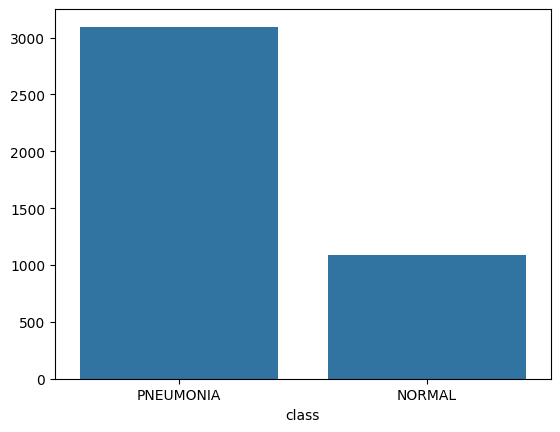

Validation classes:
class
PNEUMONIA    788
NORMAL       259
Name: count, dtype: int64


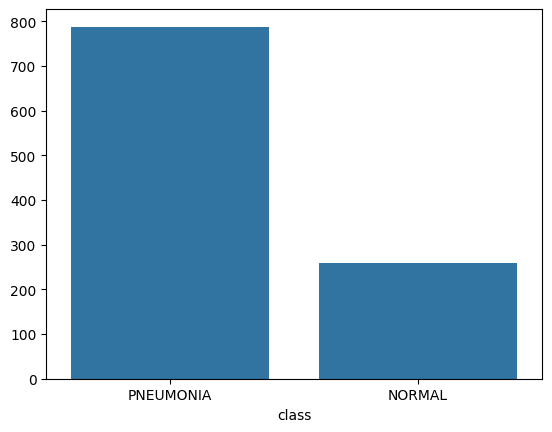

Test classes:
class
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64


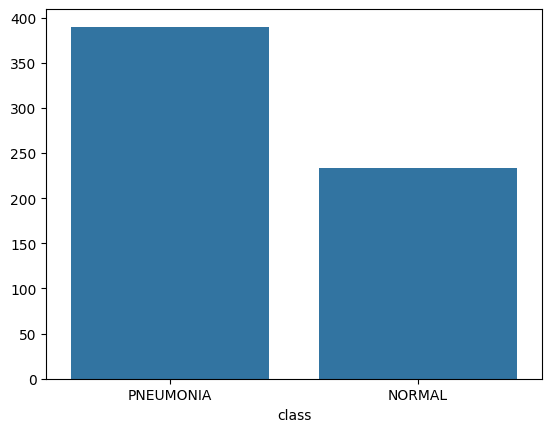

In [52]:
train_classes = train_data["class"].value_counts()
validation_classes = validation_data["class"].value_counts()
test_classes = test_data["class"].value_counts()

print("Train classes:")
print(train_classes)
sns.barplot(x=train_classes.index, y=train_classes.values)
plt.show()

print("Validation classes:")
print(validation_classes)
sns.barplot(x=validation_classes.index, y=validation_classes.values)
plt.show()

print("Test classes:")
print(test_classes)
sns.barplot(x=test_classes.index, y=test_classes.values)
plt.show()

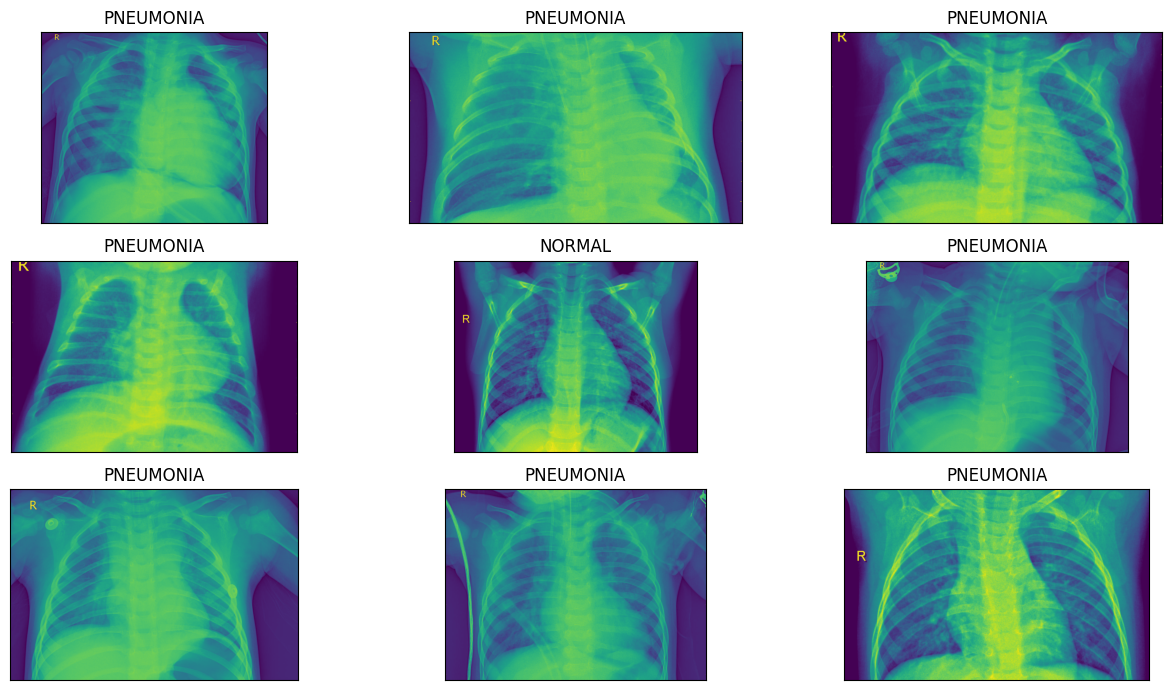

In [53]:
train_data = train_data.sample(frac=1)

f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(train_data.iloc[i]["image_path"]))
    ax.set_title(train_data.iloc[i]["class"])

plt.tight_layout()
plt.show()

In [14]:
from keras.applications import VGG16, ResNet50
from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

def create_vgg_model(learning_rate=0.001, compile=True):
    # Load pre-trained VGG16
    base_model = VGG16(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet'
    )

    for layer in base_model.layers:
      layer.trainable = False

    # Create the model
    model = models.Sequential([
        #base_model,
        #layers.Flatten(),
        #layers.Dense(128, activation='relu'),
        #layers.Dropout(0.5),
        #layers.Dense(1, activation='sigmoid')
        base_model,
        layers.Flatten(),
        
        layers.Dense(32),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(32),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')  # Para clasificación binaria
    ])

    # Compile the model
    if(compile):
      model.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss='binary_crossentropy',
          metrics=['accuracy']
      )

    return model, base_model

def create_resnet_model(learning_rate=0.001, compile=True):
    # Load pre-trained ResNet50
    base_model = ResNet50(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        #layers.Dense(128, activation='relu'),
        #layers.Dropout(0.4),
        #layers.Dense(1, activation='sigmoid')

        layers.BatchNormalization(),

        layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),

        layers.Dense(1, activation='sigmoid')  # Para clasificación binaria
    ])

    # Compile the model
    if(compile):
      model.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss='binary_crossentropy',
          metrics=['accuracy']
      )

    return model

def get_callbacks(model_name):
    """Get training callbacks"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1,
            verbose=1
        )
    ]
    return callbacks

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Detailed model comparison
def evaluate_model(model, test_images, training_images):
    """Evaluate model and return detailed metrics"""
    # Predictions
    y_pred = model.predict(test_images)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    labels = (training_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    y_pred_classes = [labels[k] for k in y_pred_classes]
    y_true_classes =  test_data["class"].values

    # Metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)

    # Classification report
    report = classification_report(y_true_classes, y_pred_classes,
                                   target_names=labels, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'pred_classes': y_pred_classes,
        'true_classes': y_true_classes
    }

print("Model building functions defined")

Model building functions defined


In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data["class"]),
    y=train_data["class"]
)

# Convierte a dict para usar en model.fit()
class_weights_dict = dict(enumerate(class_weights))


# VGG16

In [15]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# Create and train VGG model
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess, zoom_range = 0.2, width_shift_range = 0.1, height_shift_range = 0.1, rotation_range=10)
#train_datagen = ImageDataGenerator(
#    preprocessing_function=vgg_preprocess,
#    rotation_range=15,                # Rotaciones leves
#    zoom_range=0.15,                  # Zoom más amplio
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    shear_range=0.1,                  # Deformación en diagonal
#    horizontal_flip=True,            # Inversión horizontal
#    fill_mode='nearest'              # Cómo rellenar los bordes
#)
training_images = train_datagen.flow_from_dataframe(train_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', shuffle=True, seed=RANDOM_STATE,
                                            target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)
validation_images = test_datagen.flow_from_dataframe(validation_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)
test_images = test_datagen.flow_from_dataframe(test_data, x_col="image_path", y_col="class", color_mode='rgb', class_mode='binary',
                                        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [16]:
import tensorflow as tf

print("Creating VGG16 model...")
tf.keras.backend.clear_session()
vgg_model, base_vgg = create_vgg_model(LEARNING_RATE)
vgg_model.summary()

# Train VGG model
print("\nTraining VGG16 model...")
vgg_history = vgg_model.fit(
    training_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_images,
    callbacks=get_callbacks('vgg'),
    class_weight=class_weights_dict
)

# Evaluate VGG model
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(test_images)
print(f"\nVGG16 Test Accuracy: {vgg_test_acc:.4f}")
print(f"VGG16 Test Loss: {vgg_test_loss:.4f}")

Creating VGG16 model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,518,881 (59.20 MB)

 Trainable params: 804,065 (3.07 MB)

 Non-trainable params: 14,714,816 (56.13 MB)


Training VGG16 model...


/home/lucianopulido/.anaconda3/envs/diabetes/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 581s 4s/step - accuracy: 0.7580 - loss: 0.6016 - val_accuracy: 0.7650 - val_loss: 0.4875 - learning_rate: 1.0000e-04
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step - accuracy: 0.8639 - loss: 0.3842 - val_accuracy: 0.8013 - val_loss: 0.4368 - learning_rate: 1.0000e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.8931 - loss: 0.3222 - val_accuracy: 0.8300 - val_loss: 0.3916 - learning_rate: 1.0000e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 598s 5s/step - accuracy: 0.9081 - loss: 0.2818 - val_accuracy: 0.8453 - val_loss: 0.3691 - learning_rate: 1.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9131 - loss: 0.2603
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
131/131 ━━━━━━━━━━━━━━━━━━━━ 588s 4s/step - accuracy: 0.9133 - loss: 0.2601 - val_accuracy: 0.8453 - val_loss: 0.3698 - learning_rate: 1.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 

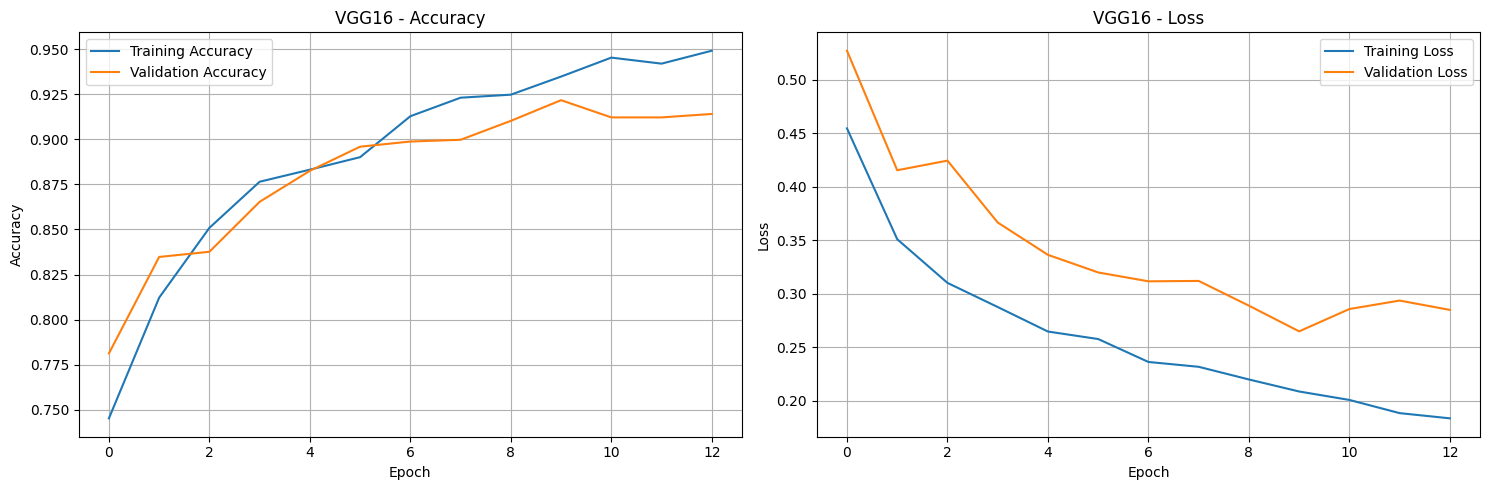

In [ ]:
# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# VGG Training History
axes[0].plot(vgg_history.history['accuracy'], label='Training Accuracy')
axes[0].plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('VGG16 - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(vgg_history.history['loss'], label='Training Loss')
axes[1].plot(vgg_history.history['val_loss'], label='Validation Loss')
axes[1].set_title('VGG16 - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
vgg_results = evaluate_model(vgg_model, test_images, training_images)

20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step


In [18]:
vgg_results['accuracy']

0.9310897435897436

<Axes: >

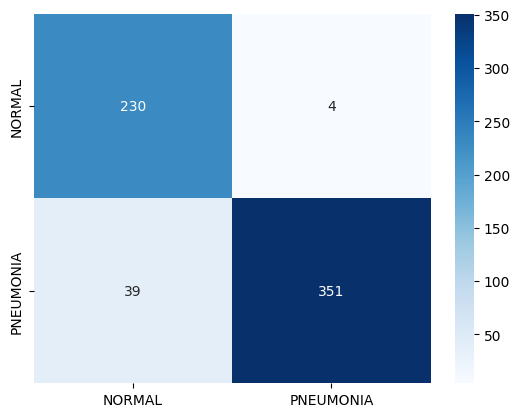

In [19]:
sns.heatmap(vgg_results['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

In [20]:
pd.DataFrame(vgg_results['report'])

,0,1,accuracy,macro avg,weighted avg
precision,0.855019,0.988732,0.93109,0.921875,0.938590
recall,0.982906,0.900000,0.93109,0.941453,0.931090
f1-score,0.914513,0.942282,0.93109,0.928397,0.931869
support,234.000000,390.000000,0.93109,624.000000,624.000000


In [21]:
vgg_model.save_weights('vgg_best.weights.h5')

In [ ]:
fine_tune_vgg, base = create_vgg_model(compile=False)
fine_tune_vgg.load_weights('vgg_best.weights.h5')

for layer in base.layers[-2:]:
  layer.trainable = True

fine_tune_vgg.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
history_finetune = fine_tune_vgg.fit(
    training_images,
    epochs=fine_tune_epochs,
    validation_data=validation_images,
    callbacks=get_callbacks('vgg_finetune'),
    class_weight=class_weights_dict
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9828 - loss: 0.0541 - val_accuracy: 0.9570 - val_loss: 0.1336 - learning_rate: 1.0000e-05
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9882 - loss: 0.0472 - val_accuracy: 0.9589 - val_loss: 0.1349 - learning_rate: 1.0000e-05
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9866 - loss: 0.0533 - val_accuracy: 0.9580 - val_loss: 0.1217 - learning_rate: 1.0000e-05
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9884 - loss: 0.0488 - val_accuracy: 0.9599 - val_loss: 0.1294 - learning_rate: 1.0000e-05
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9888 - loss: 0.0469 - val_accuracy: 0.9599 - val_loss: 0.1200 - learning_rate: 1.0000e-05
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9899 - loss: 0.0397 - val_accuracy: 0.9608 - val_loss: 0.1222 - learning_rate: 1.0000e-05
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9889 - loss

In [ ]:
vgg_tune_results = evaluate_model(vgg_model, test_images, training_images)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step


In [ ]:
vgg_tune_results['accuracy']

0.9599358974358975

<Axes: >

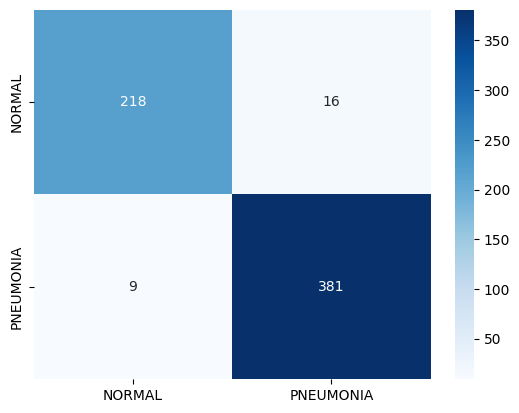

In [ ]:
sns.heatmap(vgg_tune_results['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

# ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Create and train VGG model
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess, zoom_range = 0.1, width_shift_range = 0.1, height_shift_range = 0.1)
training_images = train_datagen.flow_from_dataframe(train_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', shuffle=True, seed=RANDOM_STATE,
                                            target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
validation_images = test_datagen.flow_from_dataframe(validation_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)
test_images = test_datagen.flow_from_dataframe(test_data, x_col="image_path", y_col="class", color_mode='rgb', class_mode='binary',
                                        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)
# Create and train ResNet model
print("Creating ResNet50 model...")
resnet_model = create_resnet_model(learning_rate=LEARNING_RATE)
resnet_model.summary()

# Train ResNet model
print("\nTraining ResNet50 model...")
resnet_history = resnet_model.fit(
    training_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_images,
    callbacks=get_callbacks('resnet'),
    verbose=1
)

# Evaluate ResNet model
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_images)
print(f"\nResNet50 Test Accuracy: {resnet_test_acc:.4f}")
print(f"ResNet50 Test Loss: {resnet_test_loss:.4f}")

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Creating ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,817 (91.01 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 23,592,064 (90.00 MB)


Training ResNet50 model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6958 - loss: 0.6059 - val_accuracy: 0.6562 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8932 - loss: 0.3033 - val_accuracy: 0.8329 - val_loss: 0.4418 - learning_rate: 1.0000e-04
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9225 - loss: 0.2423 - val_accuracy: 0.8902 - val_loss: 0.3402 - learning_rate: 1.0000e-04
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9434 - loss: 0.2044 - val_accuracy: 0.9198 - val_loss: 0.2801 - learning_rate: 1.0000e-04
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9431 - loss: 0.2007 - val_accuracy: 0.9322 - val_loss: 0.2395 - learning_rate: 1.0000e-04
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9576 - loss: 0.1558 - val_accuracy: 0.9417 - val_loss: 0.2207 - learning_rate: 1.0000e-04
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9533 - los

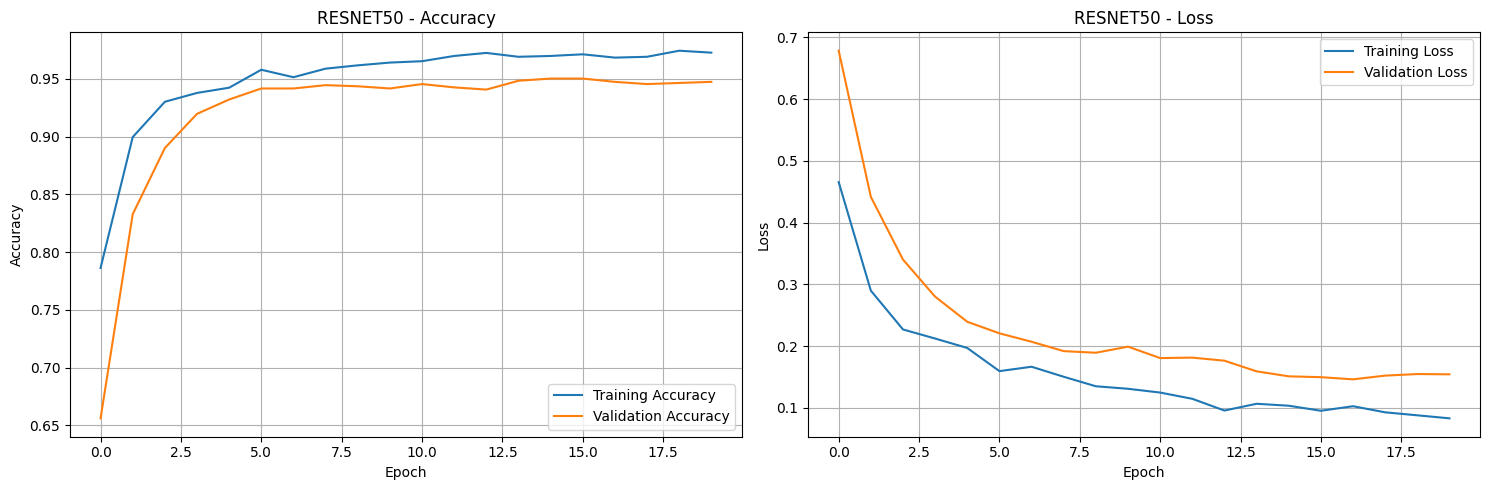

In [ ]:
# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# VGG Training History
axes[0].plot(resnet_history.history['accuracy'], label='Training Accuracy')
axes[0].plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('RESNET50 - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(resnet_history.history['loss'], label='Training Loss')
axes[1].plot(resnet_history.history['val_loss'], label='Validation Loss')
axes[1].set_title('RESNET50 - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
resnet_results = evaluate_model(resnet_model, test_images, training_images)

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 946ms/step


In [ ]:
resnet_results['accuracy']

0.9487179487179487

<Axes: >

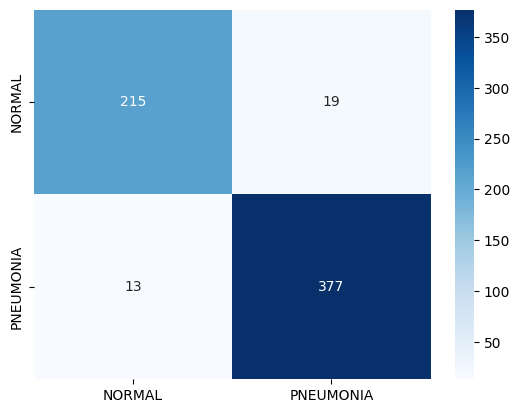

In [ ]:
sns.heatmap(resnet_results['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

In [ ]:
pd.DataFrame(resnet_results['report'])

,0,1,accuracy,macro avg,weighted avg
precision,0.942982,0.952020,0.948718,0.947501,0.948631
recall,0.918803,0.966667,0.948718,0.942735,0.948718
f1-score,0.930736,0.959288,0.948718,0.945012,0.948581
support,234.000000,390.000000,0.948718,624.000000,624.000000


In [ ]:
vgg_model.save_weights('resnet_best.weights.h5')

In [ ]:
fine_tune_resnet, base = create_resnet_model(compile=False)
fine_tune_resnet.load_weights('resnet_best.weights.h5')

for layer in base.layers[-10:]:
  layer.trainable = True

fine_tune_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.0000075),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
history_finetune = fine_tune_resnet.fit(
    training_images,
    epochs=fine_tune_epochs,
    validation_data=validation_images,
    callbacks=get_callbacks('vgg_finetune'),
    class_weight=class_weights_dict
)

TypeError: cannot unpack non-iterable Sequential object

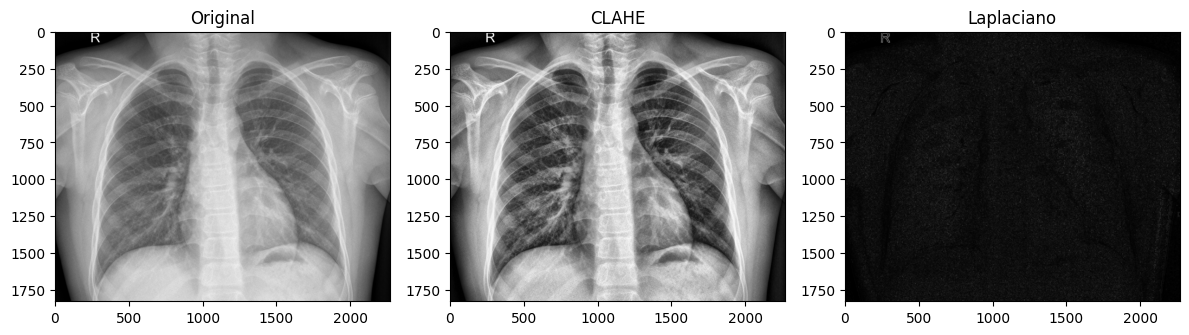

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_clahe_and_laplacian(image_path):
    # Leer la imagen en escala de grises
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_clahe = clahe.apply(image_gray)

    # Aplicar filtro Laplaciano para marcar bordes
    laplacian = cv2.Laplacian(image_clahe, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)  # Convertir a uint8 para visualización

    return image_clahe, laplacian

# Ejemplo de uso:
image_clahe, image_edges = apply_clahe_and_laplacian("dataset/chest_xray/test/NORMAL/NORMAL-71002-0001.jpeg")

# Mostrar resultados
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(cv2.imread("dataset/chest_xray/test/NORMAL/NORMAL-71002-0001.jpeg", cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(image_clahe, cmap='gray')
plt.title("CLAHE")
plt.subplot(1,3,3)
plt.imshow(image_edges, cmap='gray')
plt.title("Laplaciano")
plt.tight_layout()
plt.show()

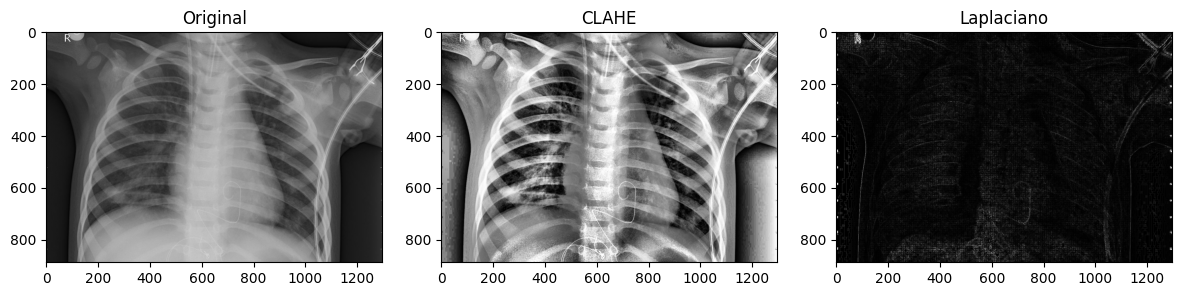

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_clahe_and_laplacian(image_path):
    # Leer la imagen en escala de grises
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=100.0, tileGridSize=(8, 8))
    image_clahe = clahe.apply(image_gray)

    # Aplicar filtro Laplaciano para marcar bordes
    laplacian = cv2.Laplacian(image_clahe, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)  # Convertir a uint8 para visualización

    return image_clahe, laplacian

# Ejemplo de uso:
image_clahe, image_edges = apply_clahe_and_laplacian("dataset/chest_xray/test/PNEUMONIA/BACTERIA-1514320-0001.jpeg")

# Mostrar resultados
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(cv2.imread("dataset/chest_xray/test/PNEUMONIA/BACTERIA-1514320-0001.jpeg", cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(image_clahe, cmap='gray')
plt.title("CLAHE")
plt.subplot(1,3,3)
plt.imshow(image_edges, cmap='gray')
plt.title("Laplaciano")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sobel')

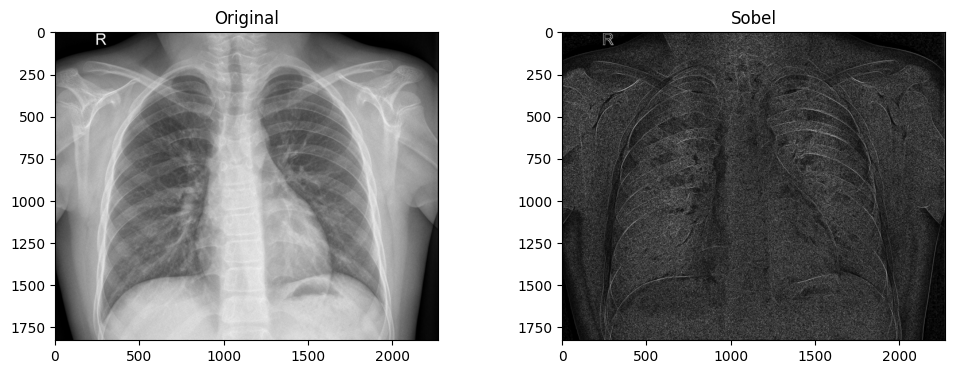

In [45]:
import cv2
import numpy as np

def apply_clahe_and_sobel(image_path):
    # Leer imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"No se encontró la imagen en la ruta: {image_path}")

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_clahe = clahe.apply(image)

    # Aplicar Sobel para detección de bordes
    sobel_x = cv2.Sobel(image_clahe, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image_clahe, cv2.CV_64F, 0, 1, ksize=3)

    # Magnitud del gradiente
    sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
    sobel_magnitude = cv2.convertScaleAbs(sobel_magnitude)  # Convertir a uint8

    return sobel_magnitude

# Ejemplo de uso:
image_sobel = apply_clahe_and_sobel("dataset/chest_xray/test/NORMAL/NORMAL-71002-0001.jpeg")

# Mostrar resultados
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(cv2.imread("dataset/chest_xray/test/NORMAL/NORMAL-71002-0001.jpeg", cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(image_sobel, cmap='gray')
plt.title("Sobel")

Text(0.5, 1.0, 'Neumonía')

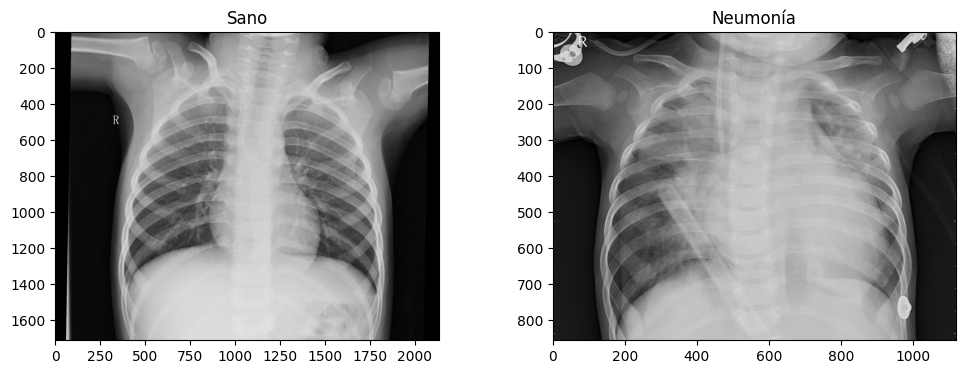

In [4]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(cv2.imread("dataset/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg", cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Sano")
plt.subplot(1,2,2)
plt.imshow(cv2.imread("dataset/chest_xray/test/PNEUMONIA/BACTERIA-518323-0002.jpeg", cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Neumonía")